In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import plotly.express as px 
from statsmodels.stats import weightstats

default_figsize = (12.8, 4.8)

### Biggest meat consumers VS biggest veggies consumer

We are also interested in looking at the consumption of the big meat and vegetables spenders. What are the other types of products that they buy ?

To do this analysis, we consider households as big meat/vegeatables if  they are in the 4th quartile of meat/vegetables spendings.

#### Load Data

In [3]:
spent_by_household = pd.read_csv("data/spent_by_household.csv")

df_transactions = pd.read_csv("data/clean_transactions.csv")
df_food_transactions = pd.read_csv("data/food_transactions.csv")

df_pure_meat = pd.read_csv('data/pure_meat_products.csv')
df_veggies_prducts = pd.read_csv('data/vegetables_products.csv')
df_products = pd.read_csv("dunnhumby/product.csv")

#### Plot Distribution of Paid Price for Meat Types

At first, we want to know the overall spending for each meat category. 

MEAT_TYPE
PORK       1849
POULTRY    1353
BOVINE     1242
UNKNOWN    1071
SEAFOOD    1042
OVINE        52
Name: PRODUCT_ID, dtype: int64

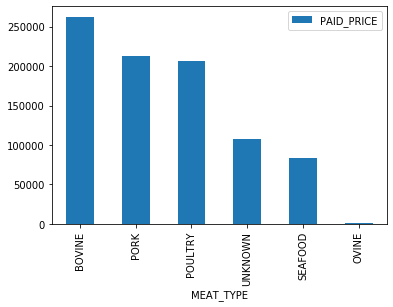

In [10]:
# Get pure meat transactions
pure_meat_transactions = pd.merge(df_transactions,df_pure_meat, on = "PRODUCT_ID", how = "inner")
pure_meat_transactions_type = pure_meat_transactions.groupby("MEAT_TYPE").agg({"PAID_PRICE" : sum})
# Plot
pure_meat_transactions_type.sort_values(by = 'PAID_PRICE',ascending = False).plot.bar();
pure_meat_transactions_type.PAID_PRICE/pure_meat_transactions_type.PAID_PRICE.sum()
df_pure_meat.groupby("MEAT_TYPE").count()["PRODUCT_ID"].sort_values(ascending=False)


It can be clearly see that bovine meat is the most popular amongst the consumers, accounting for 30% of the meat spendings. Poultry and pork meat have a very similar spending average, accounting each for 25% of the overall. The less popular meat category is ovine meat with 0.1% of the spendings.

#### Check Meat and Veggies consumed by Big Meat Consumers

In [4]:
def get_transactions(spending_type, quantile):
    # Get the transactions of the biggest meat consumers
    quantile = spending_type.quantile(quantile)
    households = spent_by_household[spending_type > quantile].household_key.values
    transactions = df_food_transactions[df_food_transactions.household_key.isin(households)]
    transactions_with_prod_info = pd.merge(transactions, df_products, how="inner")    
    return list(households), transactions_with_prod_info

Text(0.5, 1.0, 'Money spent on meat by big meat consumers')

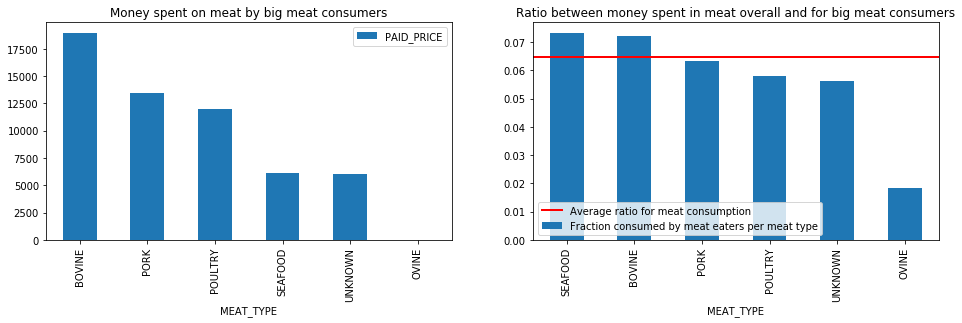

In [19]:
# Get big meat consumers transactions and households IDs
most_meat_buyers, most_meat_consumers_transactions = get_transactions(spent_by_household.ratio_spent_for_meat, quantile=0.95)

# Select only transactions for pure meat producs
most_meat_consumers_meat_transactions = pd.merge(most_meat_consumers_transactions, df_pure_meat, on = "PRODUCT_ID", how = "inner")
# Compute sum of paid price
most_meat_consumers_meat_type = most_meat_consumers_meat_transactions.groupby("MEAT_TYPE").agg({"PAID_PRICE" : sum})
# Compute Ratio spent per meat type
ratio_meat = most_meat_consumers_meat_type.copy()
ratio_meat.PAID_PRICE = ratio_meat.PAID_PRICE/pure_meat_transactions_type.PAID_PRICE
ratio = sum(most_meat_consumers_meat_type.PAID_PRICE)/sum(pure_meat_transactions_type.PAID_PRICE)
ratio_meat.rename(columns={'PAID_PRICE':'Fraction consumed by meat eaters per meat type'}, 
                 inplace=True)
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
most_meat_consumers_meat_type.sort_values(by = 'PAID_PRICE',ascending = False).plot.bar(ax = axes[0])
ratio_meat.sort_values(by = 'Fraction consumed by meat eaters per meat type',ascending = False).plot.bar(ax = axes[1]);
axes[1].axhline(y=ratio,linewidth=2, color='red', label = 'Average ratio for meat consumption')
axes[1].legend(loc = 3)
axes[1].set_title('Ratio between money spent in meat overall and for big meat consumers')
axes[0].set_title('Money spent on meat by big meat consumers')

In [10]:
# Select only transactions of Big meat consumers for Veggies meat producs
most_meat_consumers_veggie = pd.merge(most_meat_consumers_transactions, df_veggies_prducts, on = "PRODUCT_ID", how = "inner")

# Check prcts spent for meat and veggies
prct_vegg = sum(most_meat_consumers_veggie.PAID_PRICE)/sum(most_meat_consumers_transactions.PAID_PRICE)
prct_meat = sum(most_meat_consumers_meat_transactions.PAID_PRICE)/sum(most_meat_consumers_transactions.PAID_PRICE)
print('Percentage of total money spent on meat {0:.2f} and on vegetables {1:.2f} for big meat buyers.'.format(100*prct_meat,100*prct_vegg))

Percentage of total money spent on meat 38.26 and on vegetables 5.92 for big meat buyers.


We can see that big meat buyers 

#### Check Meat and Veggies consumed by Big Veggies Consumers

Text(0.5, 1.0, 'Money spent on meat by big veggie consumers')

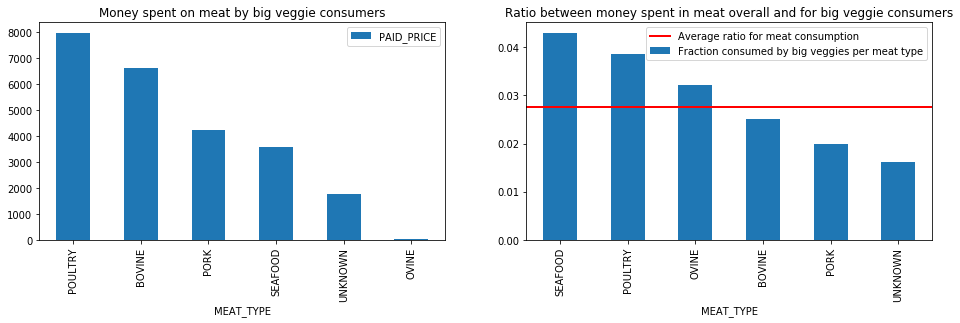

In [18]:
# Get big veggies consumers transactions and households IDs
most_veggie_buyers, most_veggie_consumers_transactions = get_transactions(spent_by_household.ratio_spent_for_veggies, quantile=0.95)

# Select only transactions for pure meat producs
most_veggie_consumers_meat_transactions = pd.merge(most_veggie_consumers_transactions,df_pure_meat, on = "PRODUCT_ID", how = "inner")
# Compute sum of paid price
most_veggie_consumers_meat_type = most_veggie_consumers_meat_transactions.groupby("MEAT_TYPE").\
    agg({"PAID_PRICE" : sum})
# Compute Ratio spent per meat type
ratio_meat = most_veggie_consumers_meat_type.copy()
ratio_meat.PAID_PRICE = ratio_meat.PAID_PRICE/pure_meat_transactions_type.PAID_PRICE
ratio = sum(most_veggie_consumers_meat_type.PAID_PRICE)/sum(pure_meat_transactions_type.PAID_PRICE)
ratio_meat.rename(columns={'PAID_PRICE':'Fraction consumed by big veggies per meat type'}, 
                 inplace=True)
# Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ratio_meat.sort_values(by = 'Fraction consumed by big veggies per meat type',ascending = False).plot.bar(ax = axes[1])
most_veggie_consumers_meat_type.sort_values(by = 'PAID_PRICE',ascending = False).plot.bar(ax = axes[0])
axes[1].axhline(y=ratio,linewidth=2, color='red', label = 'Average ratio for meat consumption')
axes[1].legend()
axes[1].set_title('Ratio between money spent in meat overall and for big veggie consumers')
axes[0].set_title('Money spent on meat by big veggie consumers')


In [ ]:
# Select only transactions of Big veggies consumers for Veggies meat producs
most_veggie_consumers_veggie = pd.merge(most_veggie_consumers_transactions,df_veggies_prducts, on = "PRODUCT_ID", how = "inner")
# Check prcts spent for meat and veggies
prct_vegg = sum(most_veggie_consumers_veggie.PAID_PRICE)/sum(most_veggie_consumers_transactions.PAID_PRICE)
prct_meat = sum(most_veggie_consumers_meat_transactions.PAID_PRICE)/sum(most_veggie_consumers_transactions.PAID_PRICE)
print('Percentage of total money spent on meat {0:.2f} and on vegetables {1:.2f} for the top 5 veggie buyers.'.format(100*prct_meat,100*prct_vegg))

In [59]:
veggie_meat_spent = most_veggie_consumers_meat_transactions.groupby('household_key').agg({"PAID_PRICE" : sum})
veggie_overall_spent = most_veggie_consumers_transactions.groupby('household_key').agg({"PAID_PRICE" : sum})
veggie_ratio = veggie_meat_spent/veggie_overall_spent
meaters_meat_spent = most_meat_consumers_meat_transactions.groupby('household_key').agg({"PAID_PRICE" : sum})
meaters_overall_spent = most_meat_consumers_transactions.groupby('household_key').agg({"PAID_PRICE" : sum})
meat_ratio = meaters_meat_spent/meaters_overall_spent
veggie_ratio = veggie_ratio.fillna(0)

weightstats.CompareMeans.from_data(veggie_ratio, meat_ratio).summary()

,coef,std err,t,P>|t|,[0.025,0.975]
subset #1,-0.2537,0.011,-23.675,0.000,-0.275,-0.233


#### Check Intersection betweem big meat buyers and big veggies buyers

In [ ]:
households_in_both = list(set(most_meat_buyers).intersection(most_veggie_buyers))
print(f"Out of those {len(most_veggie_buyers)} household, {len(households_in_both)} of them (={round((len(households_in_both) / len(biggest_meat_buyers)) * 100, 2)}%) are both bigh meat buyers and big veggies buyers.")

We only consider households that appear in one of the two groups. Doing that we have two disting groups of people.

In [ ]:
# Remove houselds that are in the two groups
biggest_meat_consumers_transactions = most_meat_consumers_transactions[~most_meat_consumers_transactions.household_key.isin(households_in_both)]
biggest_veggie_consumers_transactions = most_veggie_consumers_transactions[~most_veggie_consumers_transactions.household_key.isin(households_in_both)]

#### Look at the 15 most common commodities for each group

In [ ]:
top_15_meat = most_meat_consumers_transactions.groupby("SUB_COMMODITY_DESC")["PAID_PRICE"]\
                                   .sum()\
                                   .sort_values(ascending=False)[:20]
top_15_veggies = most_veggie_consumers_transactions.groupby("SUB_COMMODITY_DESC")["PAID_PRICE"]\
                                     .sum()\
                                     .sort_values(ascending=False)[:20]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,4))
top_15_meat.plot.bar(ax=axes[0]);
top_15_veggies.plot.bar(ax=axes[1]);
axes[0].set_title("Most Common Sub Commodities for Big Meat Buyers");
axes[1].set_title("Most Common Sub Commodities for Big Veggies Buyers");

#### Compare the 2 groups on some selected commodities

In [ ]:
selected_commodities = [
    "FRUIT - SHELF STABLE",
    "SOFT DRINKS",
    "BAG SNACKS",
    "YOGURT",
    "CHEESE",
    "FLUID MILK PRODUCTS",
    "COFFEE",
    "TEAS",
    "VEGETABLES - SHELF STABLE",
    "BEEF",
]

def get_count_by_commodity(df, commodities):
    filtered = df[df.COMMODITY_DESC.isin(commodities)]
    return filtered[["COMMODITY_DESC"]].reset_index().groupby("COMMODITY_DESC")["index"].count().reset_index(name="count")

counts_per_commodity_meat = get_count_by_commodity(most_meat_consumers_transactions, selected_commodities)
counts_per_commodity_veggies = get_count_by_commodity(most_veggie_consumers_transactions, selected_commodities)

counts_per_commodity_meat['hue']="Big meat buyers"
counts_per_commodity_veggies['hue']="Big Veggies buyers"
res=pd.concat([counts_per_commodity_meat, counts_per_commodity_veggies])

plt.figure(figsize=(20,5))
plt.title ("Big meat buyers vs big Veggies buyers")
plot = sns.barplot(x='COMMODITY_DESC',y='count',data=res,hue='hue')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
plt.show()